### Reconstruct distance maps

In [1]:
import torch
from torch import nn
import distance_heatmap
from distance_heatmap.distance_heatmap import Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [312]:
# Source flattened distance map (example)
source1 = '/media/the_beast/A/mathisi_tests/data/transformed/the_100/direct_neighbour/4ajk'

In [313]:
with open(source1, 'rb') as labels_file:
    df1 = pickle.load(labels_file)
print(df1)
print(df1.shape)
print(100*99/2)

tensor([0.0203, 0.0309, 0.0302,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
torch.Size([4950])
4950.0


In [314]:
# Remove the padding that was given during data processing

non_zero = []
non_zero.clear()
for i in df1:
    if i == 0:
        pass
    else:
        non_zero.append(i)

non_zeroed = torch.tensor(non_zero, dtype=torch.float64)
print(non_zeroed)
print(non_zeroed.shape)

tensor([0.0203, 0.0309, 0.0302,  ..., 0.0123, 0.0249, 0.0328],
       dtype=torch.float64)
torch.Size([3160])


In [54]:
# Function to calculate the value of n, being the original size of the protein & n x n dimensions of the original distance matrix
# I hope you like the name
cache = {}
def golden_triangle(n):   
    if n in cache:
        return cache[n]  
    if n == 4:
        value = 6
    elif n == 5:
        value = 10
    elif n == 6:
        value = 15
    elif n > 6:
        value = golden_triangle(n-1) + n - 1        
    cache[n] = value
    
    return value

In [315]:
# Stupid manul part to identify the value of n by "trial & error" - yes, I am ashamed

x = golden_triangle(80)
print(non_zeroed.shape[0] - x)

0


In [316]:
# Once you have the value of n, set the variable span to this value
# This code will tag the flattened matrix at what should be the non zero entries. In the next step, the non zero
# entries will be populated by the values from the model output (or test flattened dstance matrix in this example)
span = 80
holder = torch.flatten(torch.zeros(span, span)) # Create an empty matrix & flatten, of the correct dimension of n
counter = 0
while counter <= span:
    for s in range(int(span**2 / span)): # Was divded by 4, changed to span
        s = s + span * counter
        if s == holder.shape[0]:
            break
        if s % span == 0:
            holder[s] = 0
        elif s % span <= counter:
            holder[s] = 0
        else:
            try:
                holder[s] = 5
            except:
                pass
    s += 1
    counter += 1


print(holder)
print(holder.shape)

tensor([0., 5., 5.,  ..., 0., 0., 0.])
torch.Size([6400])


In [317]:
# Replaces the non zero entries of the flattened matrix that will reconsitute the distance matrix using the
# values from the model output

counter_2 = 0
for num in range(holder.shape[0]):
    if holder[num] == 5:
        holder[num] = non_zeroed[counter_2]
        counter_2 += 1
print(holder)
print(holder.shape)

tensor([0.0000, 0.0203, 0.0309,  ..., 0.0000, 0.0000, 0.0000])
torch.Size([6400])


In [318]:
# Reconstitute the distance matrix

unflattened = torch.reshape(holder, (span, span))
triangle = unflattened.T
matrix = unflattened + triangle
matrix

tensor([[0.0000, 0.0203, 0.0309,  ..., 0.0196, 0.0304, 0.0313],
        [0.0203, 0.0000, 0.0123,  ..., 0.0022, 0.0125, 0.0232],
        [0.0309, 0.0123, 0.0000,  ..., 0.0125, 0.0015, 0.0319],
        ...,
        [0.0196, 0.0022, 0.0125,  ..., 0.0000, 0.0123, 0.0249],
        [0.0304, 0.0125, 0.0015,  ..., 0.0123, 0.0000, 0.0328],
        [0.0313, 0.0232, 0.0319,  ..., 0.0249, 0.0328, 0.0000]])

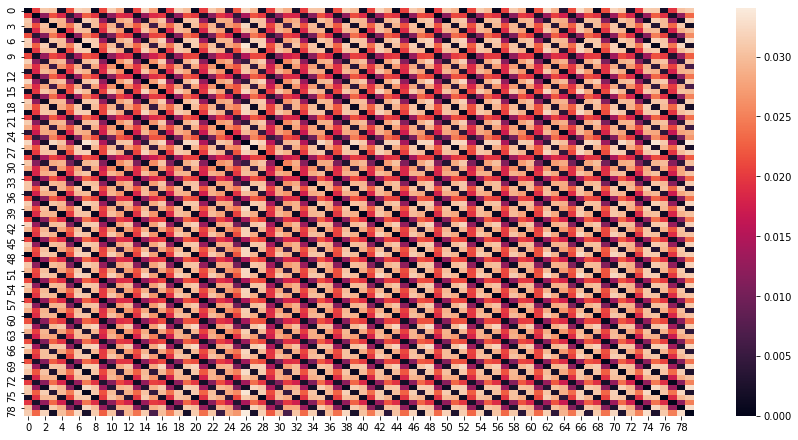

In [319]:
# Plot the heatmap of the reconsituted distance matrix

plt.figure(figsize = (15,7.5))
ax = sns.heatmap(matrix)
plt.show()

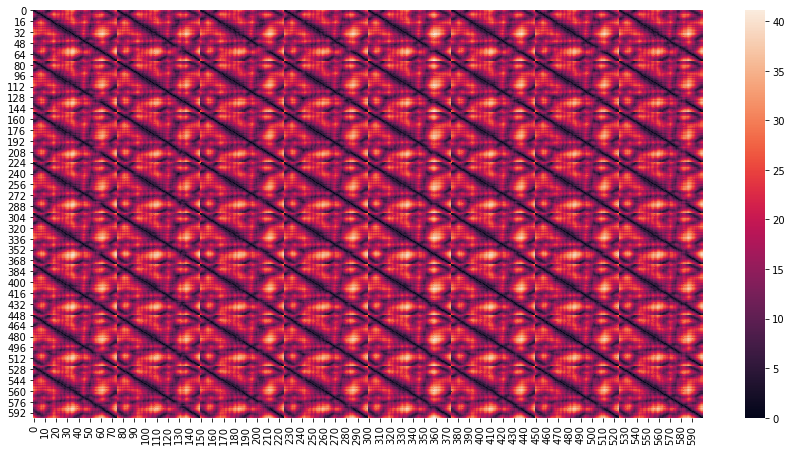

In [5]:
# Plot the heatmap of the original distance matrix (before data processing)

source2 = '/media/the_beast/B/mathisi_tests/data/closed_dataset/testset/distance_matrix/2mbe_label.pickle'
heat = Heatmap(source2)
heat.loader()
heat.make_distance_map()

In [169]:
# Compare shapes

with open(source2, 'rb') as labels_file:
    df2 = pickle.load(labels_file)
print(df2.shape)
print(matrix.shape)

torch.Size([89, 89])
torch.Size([80, 80])


In [96]:
# Compare matricies

print(df2)
print(matrix * 313)

tensor([[ 0.0000,  3.8126,  6.3778,  ..., 30.0532, 32.0786, 35.5001],
        [ 3.8126,  0.0000,  3.8092,  ..., 29.3332, 31.5041, 34.7286],
        [ 6.3778,  3.8092,  0.0000,  ..., 27.8351, 29.7264, 32.7710],
        ...,
        [30.0532, 29.3332, 27.8351,  ...,  0.0000,  3.8135,  6.7165],
        [32.0786, 31.5041, 29.7264,  ...,  3.8135,  0.0000,  3.8626],
        [35.5001, 34.7286, 32.7710,  ...,  6.7165,  3.8626,  0.0000]],
       dtype=torch.float64)
tensor([[ 0.0000,  3.8126,  6.3778,  ..., 30.0532, 32.0786, 35.5001],
        [ 3.8126,  0.0000,  3.8092,  ..., 29.3332, 31.5041, 34.7286],
        [ 6.3778,  3.8092,  0.0000,  ..., 27.8351, 29.7264, 32.7710],
        ...,
        [30.0532, 29.3332, 27.8351,  ...,  0.0000,  3.8135,  6.7165],
        [32.0786, 31.5041, 29.7264,  ...,  3.8135,  0.0000,  3.8626],
        [35.5001, 34.7286, 32.7710,  ...,  6.7165,  3.8626,  0.0000]])


In [5]:
a = '/media/the_beast/B/mathisi_tests/data/closed_dataset/testset/distance_matrix/5pm0_label.pickle'
with open(a, 'rb') as labels_file:
    df2 = pickle.load(labels_file)

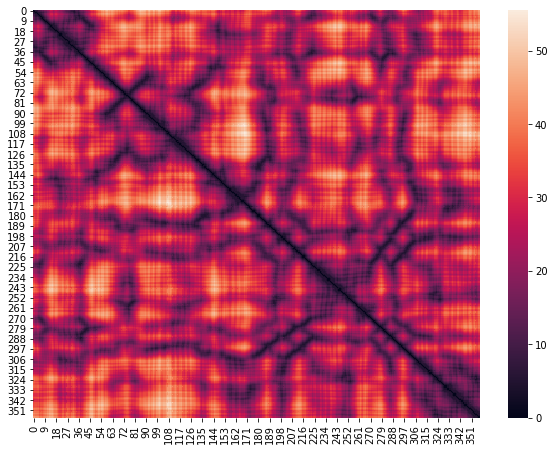

In [6]:
plt.figure(figsize = (10,7.5))
ax = sns.heatmap(df2)
plt.show()

In [308]:
with open('/media/the_beast/A/mathisi_tests/data/transformed/the_100/distance_matrix/6ber_label.pickle', 'rb') as labels_file:
    holder = pickle.load(labels_file)
    print(holder)
    print(holder.shape)

tensor([[ 0.0000,  6.3472,  9.6752,  ...,  6.1370,  9.5259,  9.8040],
        [ 6.3472,  0.0000,  3.8648,  ...,  0.6888,  3.8998,  7.2700],
        [ 9.6752,  3.8648,  0.0000,  ...,  3.9050,  0.4635,  9.9768],
        ...,
        [ 6.1370,  0.6888,  3.9050,  ...,  0.0000,  3.8647,  7.7883],
        [ 9.5259,  3.8998,  0.4635,  ...,  3.8647,  0.0000, 10.2663],
        [ 9.8040,  7.2700,  9.9768,  ...,  7.7883, 10.2663,  0.0000]],
       dtype=torch.float64)
torch.Size([80, 80])


In [310]:
flat = torch.flatten(holder)
print(flat)
print(flat.shape)
print(80**2)

tensor([ 0.0000,  6.3472,  9.6752,  ...,  7.7883, 10.2663,  0.0000],
       dtype=torch.float64)
torch.Size([6400])
6400


In [311]:
zeros = []
zeros.clear()
non_zero = []
non_zero.clear()
for i in flat:
    if i == 0:
        zeros.append(i)
    else:
        non_zero.append(i)
        
print(len(zeros))
print(len(non_zero))
print(len(zeros) + len(non_zero))

80
6320
6400


In [291]:
new_tensor = holder / 313
print(new_tensor)
print(new_tensor.shape)

tensor([[0.0000, 0.0121, 0.0211,  ..., 0.2178, 0.2153, 0.2165],
        [0.0121, 0.0000, 0.0120,  ..., 0.2147, 0.2128, 0.2137],
        [0.0211, 0.0120, 0.0000,  ..., 0.2043, 0.2026, 0.2032],
        ...,
        [0.2178, 0.2147, 0.2043,  ..., 0.0000, 0.0122, 0.0177],
        [0.2153, 0.2128, 0.2026,  ..., 0.0122, 0.0000, 0.0123],
        [0.2165, 0.2137, 0.2032,  ..., 0.0177, 0.0123, 0.0000]],
       dtype=torch.float64)
torch.Size([97, 97])


In [292]:
print(holder/313)

tensor([[0.0000, 0.0121, 0.0211,  ..., 0.2178, 0.2153, 0.2165],
        [0.0121, 0.0000, 0.0120,  ..., 0.2147, 0.2128, 0.2137],
        [0.0211, 0.0120, 0.0000,  ..., 0.2043, 0.2026, 0.2032],
        ...,
        [0.2178, 0.2147, 0.2043,  ..., 0.0000, 0.0122, 0.0177],
        [0.2153, 0.2128, 0.2026,  ..., 0.0122, 0.0000, 0.0123],
        [0.2165, 0.2137, 0.2032,  ..., 0.0177, 0.0123, 0.0000]],
       dtype=torch.float64)


In [293]:
upper_triangle = torch.triu(new_tensor, diagonal=1)
print(upper_triangle)
print(upper_triangle.shape)

tensor([[0.0000, 0.0121, 0.0211,  ..., 0.2178, 0.2153, 0.2165],
        [0.0000, 0.0000, 0.0120,  ..., 0.2147, 0.2128, 0.2137],
        [0.0000, 0.0000, 0.0000,  ..., 0.2043, 0.2026, 0.2032],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0122, 0.0177],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0123],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
torch.Size([97, 97])


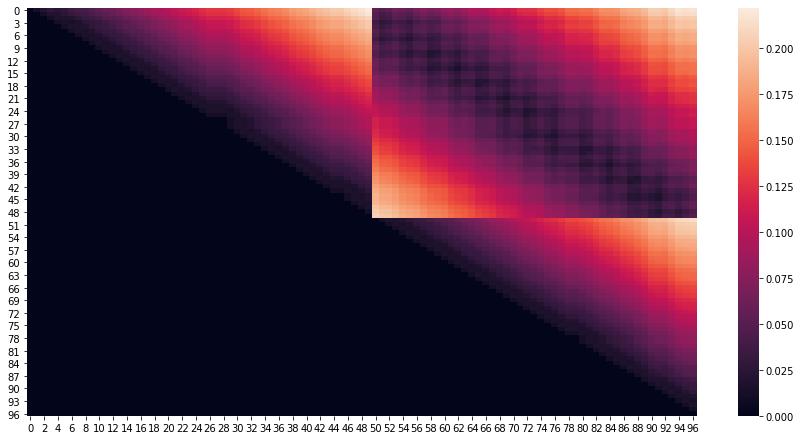

In [294]:
plt.figure(figsize = (15,7.5))
ax = sns.heatmap(upper_triangle)
plt.show()

In [295]:
flat = torch.flatten(upper_triangle)
print(flat)
print(flat.shape)

tensor([0.0000, 0.0121, 0.0211,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
torch.Size([9409])


In [296]:
97*97

9409

In [297]:
zeros = []
zeros.clear()
non_zero = []
non_zero.clear()
for i in flat:
    if i == 0:
        zeros.append(i)
    else:
        non_zero.append(i)
        
print(len(zeros))
print(len(non_zero))
print(len(zeros) + len(non_zero))
up = torch.tensor(non_zero, dtype=torch.float64)
print(up)
print(up.shape)

4753
4656
9409
tensor([0.0121, 0.0211, 0.0286,  ..., 0.0122, 0.0177, 0.0123],
       dtype=torch.float64)
torch.Size([4656])


In [298]:
97*96/2

4656.0

In [299]:
tensor_dimension = 100
target_tensor_dimension = int(tensor_dimension * (tensor_dimension - 1)/2)
pad = target_tensor_dimension - up.shape[0]

In [300]:
padded = nn.ConstantPad1d((0, pad), 0)(up)
print(padded)
print(padded.shape)

tensor([0.0121, 0.0211, 0.0286,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
torch.Size([4950])


In [301]:
100*99/2

4950.0

In [418]:
non_zero = []
non_zero.clear()
for i in tensor1:
    if i == 0:
        pass
    else:
        non_zero.append(i)

non_zeroed = torch.tensor(non_zero, dtype=torch.float64)
print(non_zeroed)
print(non_zeroed.shape)

tensor([0.0123, 0.0230, 0.0299,  ..., 0.0003, 0.0003, 0.0002],
       dtype=torch.float64)
torch.Size([179700])


In [419]:
x = golden_triangle(600)
print(non_zeroed.shape[0] - x)

0


In [420]:
span = 600
holder = torch.flatten(torch.zeros(span, span)) # Create an empty matrix & flatten, of the correct dimension of n
counter = 0
while counter <= span:
    for s in range(int(span**2 / span)): # Was divded by 4, changed to span
        s = s + span * counter
        if s == holder.shape[0]:
            break
        if s % span == 0:
            holder[s] = 0
        elif s % span <= counter:
            holder[s] = 0
        else:
            try:
                holder[s] = 5
            except:
                pass
    s += 1
    counter += 1


print(holder)
print(holder.shape)

tensor([0., 5., 5.,  ..., 0., 0., 0.])
torch.Size([360000])


In [421]:
counter_2 = 0
for num in range(holder.shape[0]):
    if holder[num] == 5:
        holder[num] = non_zeroed[counter_2]
        counter_2 += 1
print(holder)
print(holder.shape)

tensor([0.0000, 0.0123, 0.0230,  ..., 0.0000, 0.0000, 0.0000])
torch.Size([360000])


In [422]:
unflattened = torch.reshape(holder, (span, span))
triangle = unflattened.T
matrix = unflattened + triangle
matrix

tensor([[0.0000, 0.0123, 0.0230,  ..., 0.1551, 0.1234, 0.1176],
        [0.0123, 0.0000, 0.1327,  ..., 0.1001, 0.1111, 0.0986],
        [0.0230, 0.1327, 0.0000,  ..., 0.0898, 0.1047, 0.0954],
        ...,
        [0.1551, 0.1001, 0.0898,  ..., 0.0000, 0.0003, 0.0003],
        [0.1234, 0.1111, 0.1047,  ..., 0.0003, 0.0000, 0.0002],
        [0.1176, 0.0986, 0.0954,  ..., 0.0003, 0.0002, 0.0000]])

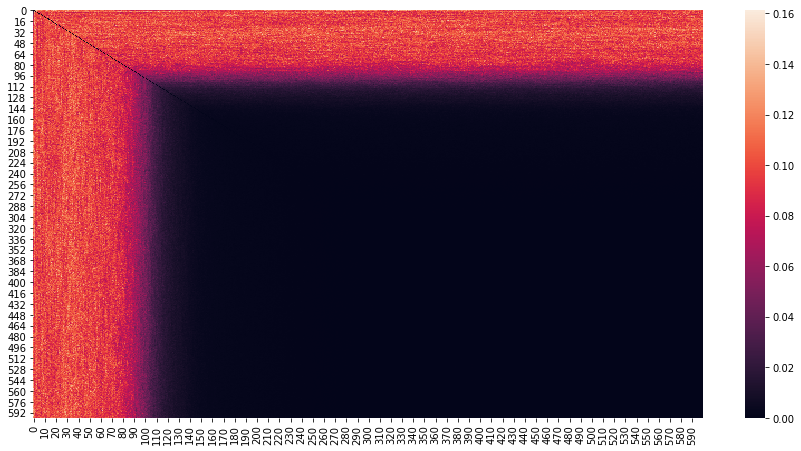

In [423]:
plt.figure(figsize = (15,7.5))
ax = sns.heatmap(matrix)
plt.show()

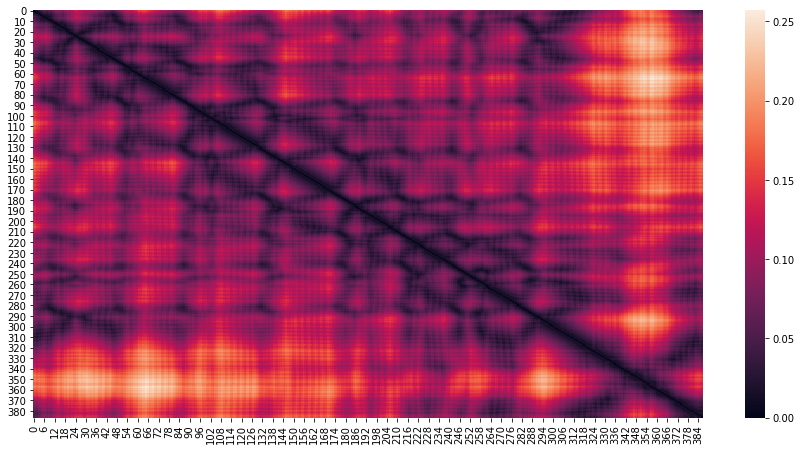

In [405]:
plt.figure(figsize = (15,7.5))
ax = sns.heatmap(matrix)
plt.show()